In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from tabulate import tabulate
from random import random
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import roc_auc_score,precision_recall_curve,auc,roc_curve
import pickle

In [2]:
import warnings 

warnings.filterwarnings("ignore") 

In [3]:
# Load data

train_path = 'dataset/Kaggle_Training_Dataset_v2.csv'
test_path = 'dataset/Kaggle_Test_Dataset_v2.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [4]:
# Preprocessing as per EDA

# Dropping last row which is invalid data
# Median encoding lead_time
# Adding sales and forecast columns
# Remove sku column
# Perform OHE on categorical data
# Perfrom MinmaxScaler transform 

train_data.drop(train_data.tail(1).index,inplace=True)

lead_time_median = train_data['lead_time'].median()
train_data['lead_time'].fillna(lead_time_median,inplace=True)
   
train_data['forecast']=(train_data['forecast_3_month']>0)|(train_data['forecast_6_month']>0)|(train_data['forecast_9_month']>0)
train_data['forecast']=train_data['forecast'].astype(int)
train_data['sales']=(train_data['sales_1_month']>0)|(train_data['sales_3_month']>0)|(train_data['sales_6_month']>0)|(train_data['sales_9_month']>0)
train_data['sales']=train_data['sales'].astype(int)

remove_cols = ['sku']

train_data = train_data.drop(labels=remove_cols,axis=1)
train_data= pd.get_dummies(train_data,drop_first=True)
scaler = MinMaxScaler()
train_data_norm = scaler.fit_transform(train_data)
train_data = pd.DataFrame(train_data_norm,columns=train_data.columns)

In [5]:
# Performing the same set of transformations on test data

test_data.drop(test_data.tail(1).index,inplace=True)

test_data['lead_time'].fillna(lead_time_median,inplace=True)
test_data['forecast']=(test_data['forecast_3_month']>0)|(test_data['forecast_6_month']>0)|(test_data['forecast_9_month']>0)
test_data['forecast']=test_data['forecast'].astype(int)
test_data['sales']=(test_data['sales_1_month']>0)|(test_data['sales_3_month']>0)|(test_data['sales_6_month']>0)|(test_data['sales_9_month']>0)
test_data['sales']=test_data['sales'].astype(int)

test_data = test_data.drop(labels=remove_cols,axis=1)
test_data= pd.get_dummies(test_data,drop_first=True)

# https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data
# Ensuring same set of columns for train and test
delta_cols = set(train_data.columns) - set(test_data.columns)

for c in delta_cols:
    test_data[c] = 0

test_data = test_data[train_data.columns]
test_data_norm = scaler.transform(test_data)
test_data = pd.DataFrame(test_data_norm,columns=test_data.columns)


In [6]:
# Separating X and target

train_x = train_data.iloc[:,:-1]
train_y = train_data.iloc[:,-1]
test_x = test_data.iloc[:,:-1]
test_y = test_data.iloc[:,-1]

In [7]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_y, predict_y):
    """
    Function to plot the confusion, precision and recall matrices
    """
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [8]:
# Undersampling with 0.2 factor then smote oversampling

train_x_rus, train_y_rus = RandomUnderSampler(0.2).fit_resample(train_x,train_y)
smote_x, smote_y = SMOTE().fit_resample(train_x_rus, train_y_rus)


In [9]:
# Training with best classifier

clf = XGBClassifier(eta=0.3,max_depth=10,eval_metric='aucpr')
clf.fit(smote_x,smote_y)
preds = clf.predict(test_x)


In [49]:
f1_score(test_y, preds)

0.24133385032958513

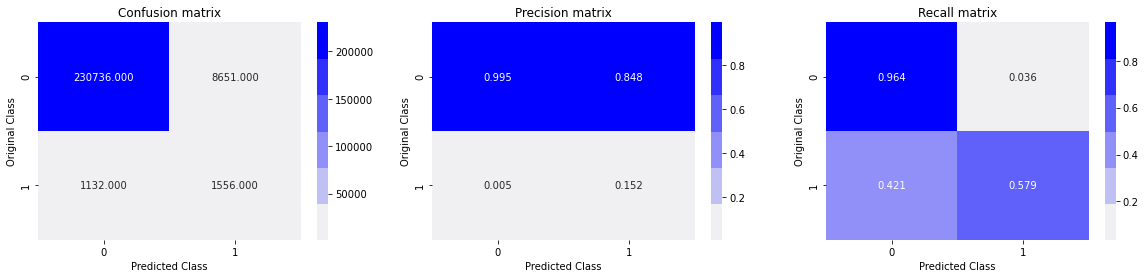

In [10]:
plot_confusion_matrix(test_y, preds)

#### Confusion matrix analysis-
1. Creating new column to indicate whether point correctly classified
2. Creating 1 data frame each for all TP, FP, TN and FN points

In [11]:
pred = pd.DataFrame(preds,columns=['pred'])

In [12]:
pred_combined = pd.concat([test_x,test_y,pred],axis=1)

In [11]:
pred_combined.columns[-3:]

Index(['rev_stop_Yes', 'went_on_backorder_Yes', 'pred'], dtype='object')

In [13]:
pred_correct = pred_combined[pred_combined['went_on_backorder_Yes']==pred_combined['pred']]
pred_incorrect = pred_combined[pred_combined['went_on_backorder_Yes']!=pred_combined['pred']]


In [51]:
pred_tp = pred_correct[pred_correct['pred']==1.0]
pred_tn = pred_correct[pred_correct['pred']==0.0]
pred_fp = pred_incorrect[pred_incorrect['pred']==1.0]
pred_fn = pred_incorrect[pred_incorrect['pred']==0.0]

#### Basic numerical row analysis for TP vs FP points:

In [52]:
pred_fp.iloc[:,:-2].describe()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,perf_12_month_avg,local_bo_qty,forecast,sales,potential_issue_Yes,deck_risk_Yes,oe_constraint_Yes,ppap_risk_Yes,stop_auto_buy_Yes,rev_stop_Yes
count,8651.000000,8651.000000,8651.000000,8651.000000,8651.000000,8651.000000,8651.000000,8.651000e+03,8.651000e+03,8.651000e+03,...,8651.000000,8651.000000,8651.000000,8651.000000,8651.000000,8651.000000,8651.000000,8651.000000,8651.000000,8651.000000
mean,0.002206,0.110434,0.000012,0.000099,0.000083,0.000071,0.000052,1.645806e-04,1.162007e-04,9.732745e-05,...,0.949618,0.000525,0.918507,0.803491,0.001965,0.156051,0.000578,0.152006,0.961045,0.000925
std,0.000067,0.070892,0.000153,0.000801,0.000580,0.000488,0.000672,7.255491e-03,3.770619e-03,2.556439e-03,...,0.212654,0.009788,0.273607,0.397381,0.044288,0.362925,0.024035,0.359047,0.193499,0.030397
min,0.000149,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.002205,0.038462,0.000000,0.000002,0.000002,0.000002,0.000000,9.045861e-07,9.316951e-07,6.239915e-07,...,0.995300,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.002205,0.153846,0.000000,0.000007,0.000006,0.000005,0.000003,5.427516e-06,4.658476e-06,4.367940e-06,...,0.997900,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.002205,0.153846,0.000000,0.000022,0.000021,0.000019,0.000009,1.809172e-05,1.677051e-05,1.591178e-05,...,0.999500,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,0.007560,1.000000,0.009981,0.039752,0.023056,0.015024,0.036548,6.712852e-01,3.460106e-01,2.318790e-01,...,1.000000,0.459697,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [53]:
pred_tp.iloc[:,:-2].describe()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,perf_12_month_avg,local_bo_qty,forecast,sales,potential_issue_Yes,deck_risk_Yes,oe_constraint_Yes,ppap_risk_Yes,stop_auto_buy_Yes,rev_stop_Yes
count,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,...,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.0
mean,0.002205,0.126706,0.000006,0.000132,0.000113,0.000100,0.000046,0.000107,0.000093,0.000090,...,0.953310,0.000472,0.960154,0.924807,0.001285,0.114396,0.000643,0.141388,0.958226,0.0
std,0.000007,0.073036,0.000068,0.000693,0.000602,0.000532,0.000230,0.000756,0.000558,0.000547,...,0.203876,0.006365,0.195660,0.263787,0.035840,0.318394,0.025351,0.348534,0.200136,0.0
min,0.001997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.002205,0.038462,0.000000,0.000004,0.000003,0.000003,0.000001,0.000004,0.000003,0.000003,...,0.994600,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
50%,0.002205,0.153846,0.000000,0.000013,0.000011,0.000010,0.000005,0.000010,0.000009,0.000009,...,0.997500,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
75%,0.002205,0.153846,0.000000,0.000039,0.000035,0.000031,0.000016,0.000030,0.000028,0.000026,...,0.999200,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
max,0.002268,1.000000,0.002192,0.011418,0.010591,0.009722,0.003548,0.023398,0.013649,0.012116,...,1.000000,0.226417,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


#### Pair plot analysis for TP vs FP points:

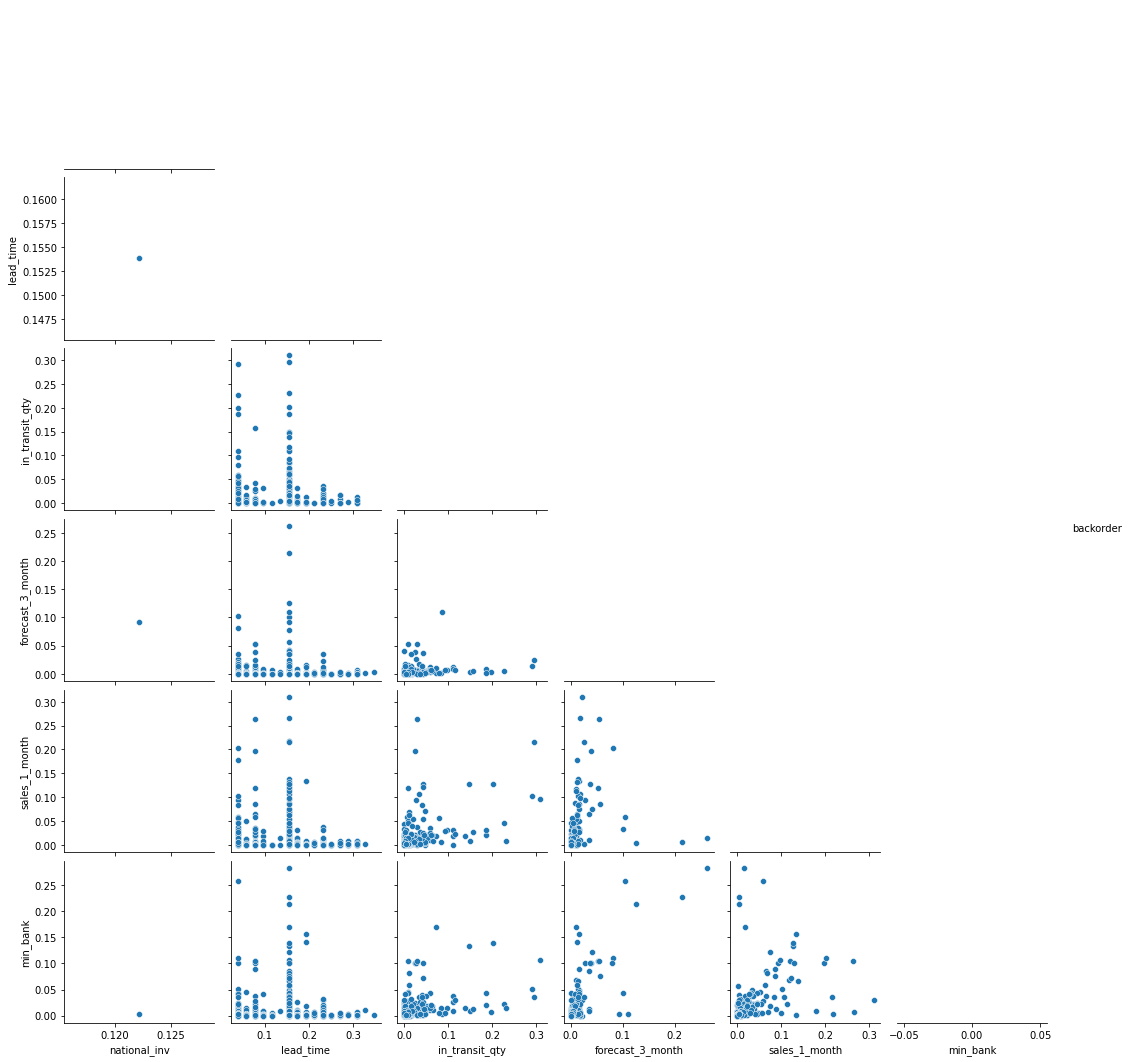

In [17]:
pair_cols = ['national_inv','lead_time','in_transit_qty','forecast_3_month','sales_1_month','min_bank']
x_pair = pred_fp[pair_cols]
cols = x_pair.columns
x_pair = MinMaxScaler().fit_transform(x_pair)
x_pair = pd.DataFrame(x_pair,columns=cols)
x_pair['backorder'] = pred_fp['went_on_backorder_Yes'] 
plot_kws={"s": 1}
sns.pairplot(x_pair[(x_pair[pair_cols]>0)&(x_pair[pair_cols]<0.4)],hue='backorder',corner='True')

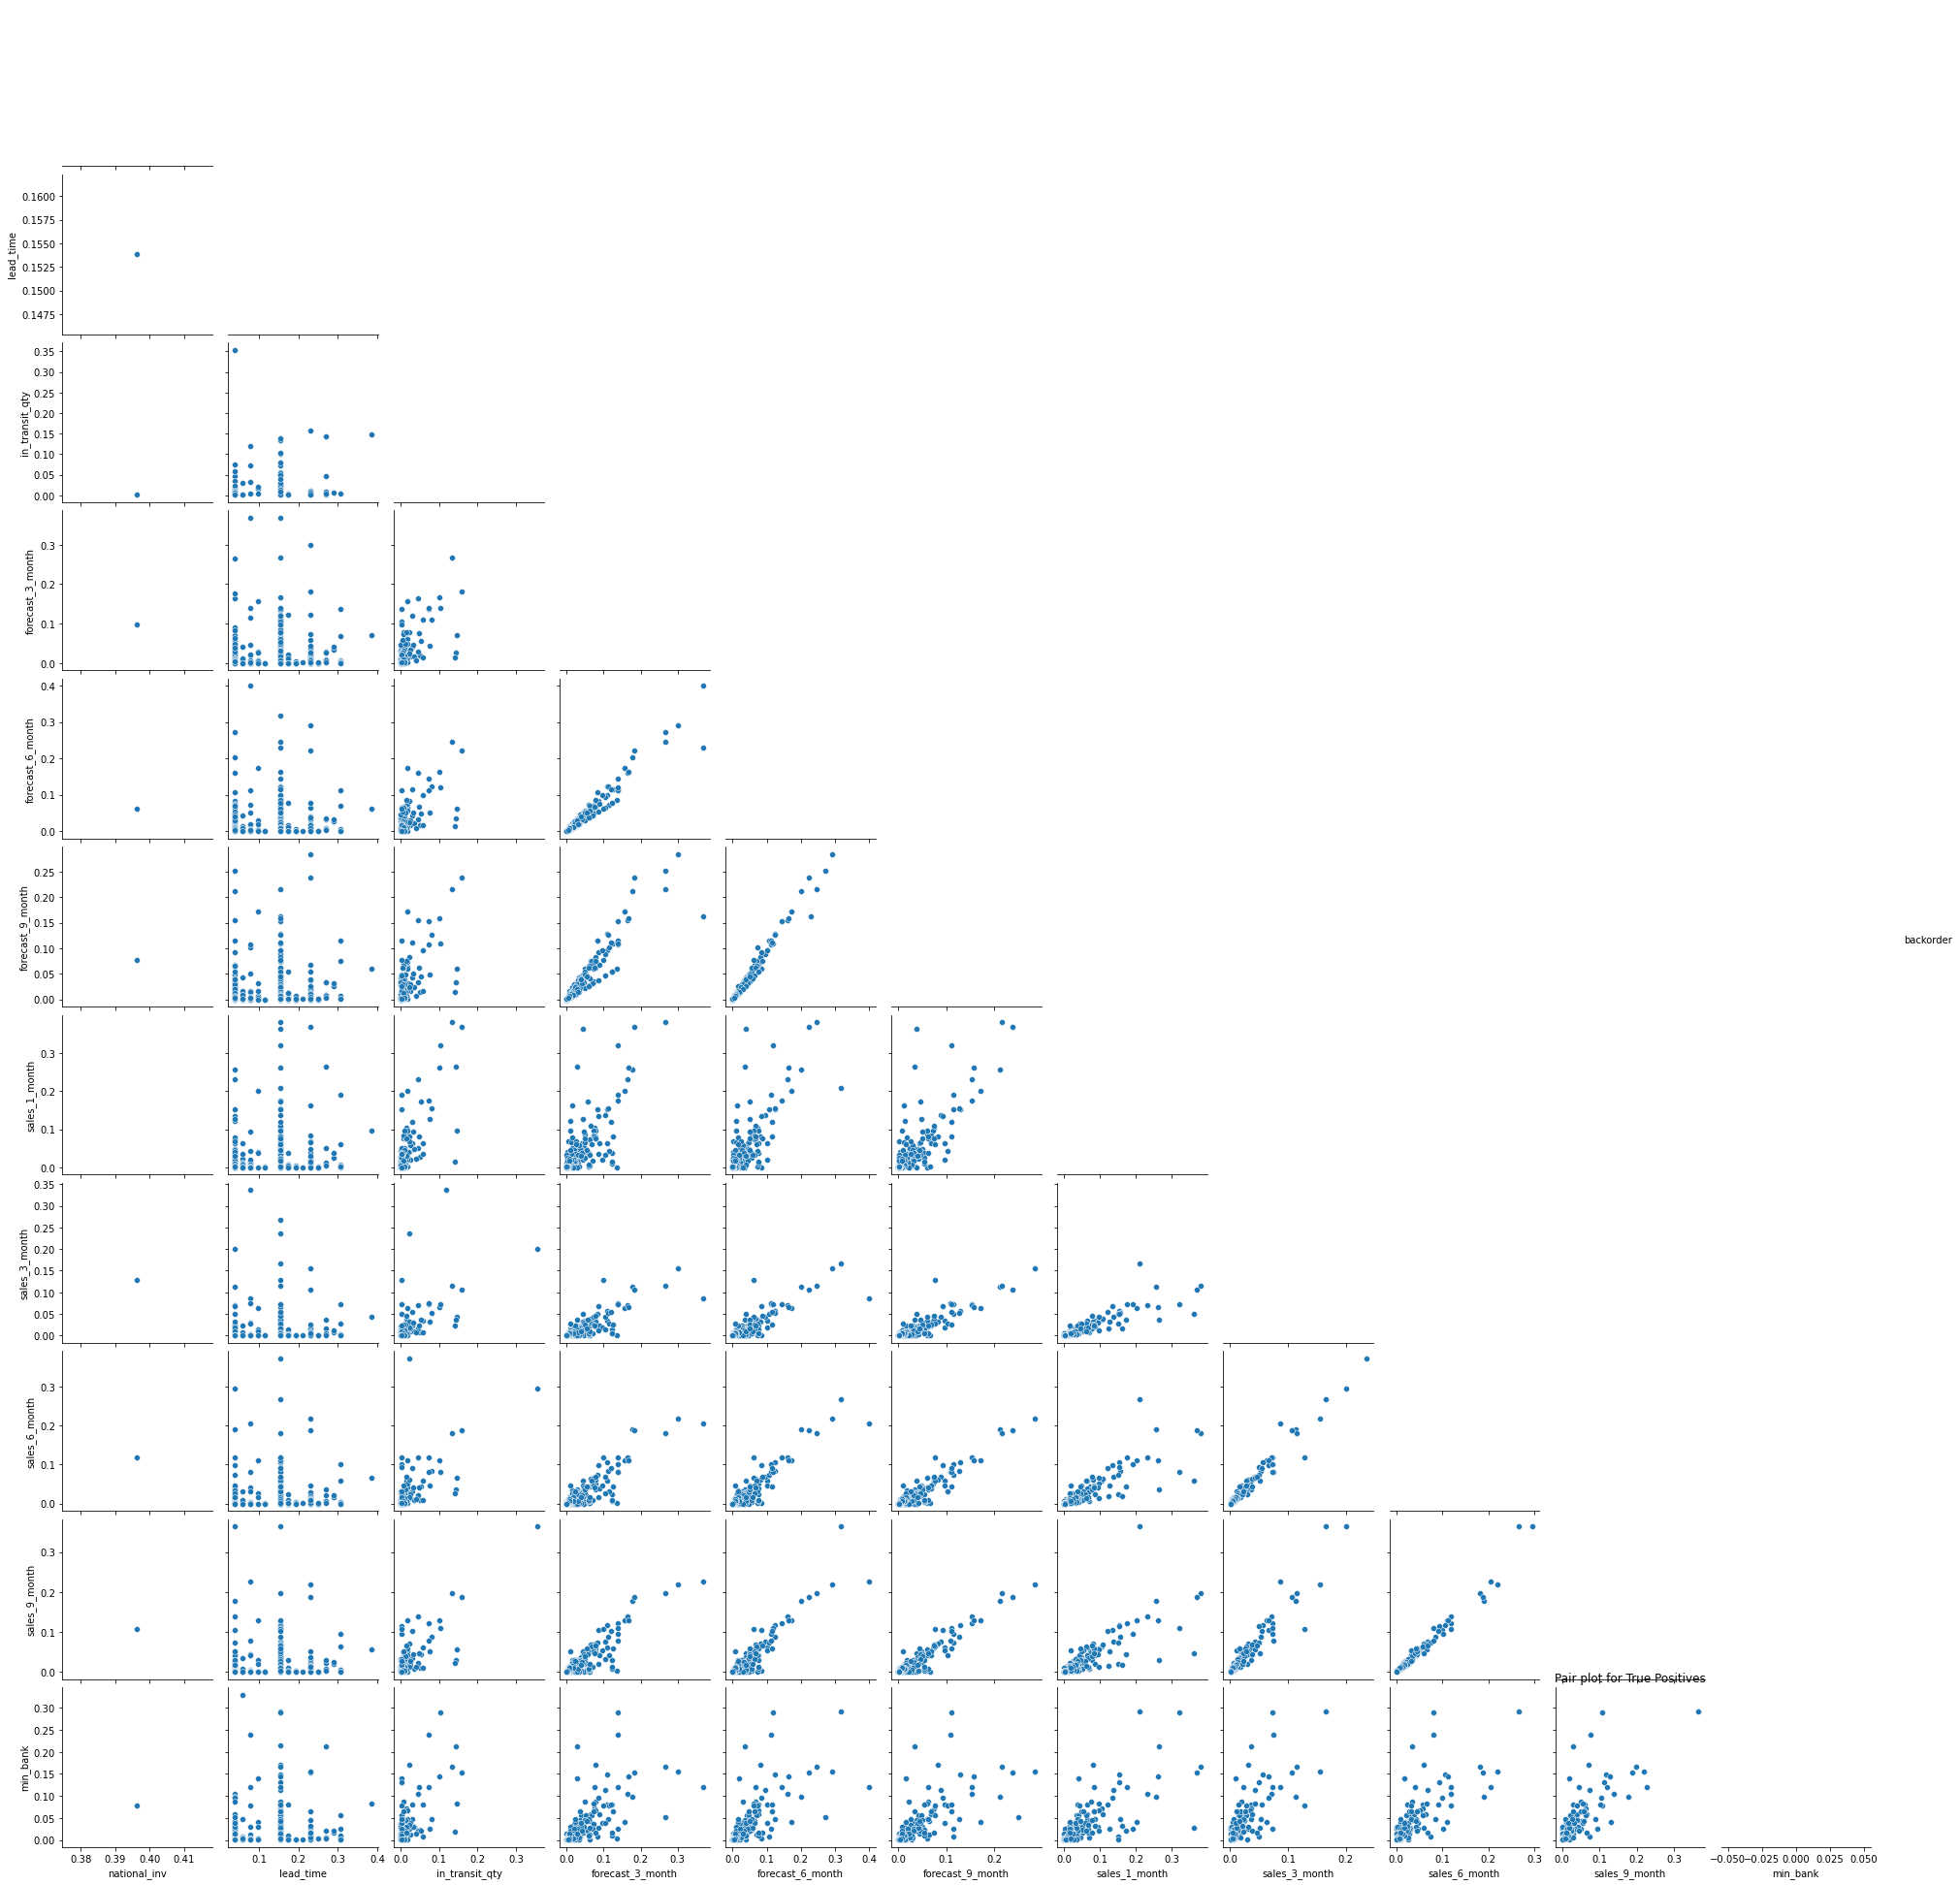

In [54]:
pair_cols = ['national_inv','lead_time','in_transit_qty','forecast_3_month','forecast_6_month','forecast_9_month','sales_1_month','sales_3_month','sales_6_month','sales_9_month','min_bank']
x_pair = pred_tp[pair_cols]
cols = x_pair.columns
x_pair = MinMaxScaler().fit_transform(x_pair)
x_pair = pd.DataFrame(x_pair,columns=cols)
x_pair['backorder'] = pred_tp['went_on_backorder_Yes'] 
plot_kws={"s": 1}
sns.pairplot(x_pair[(x_pair[pair_cols]>0)&(x_pair[pair_cols]<0.4)],hue='backorder',corner='True')
plt.title("Pair plot for True Positives")
plt.show()

#### Analysis of zero value percentages in confusion matrix format:

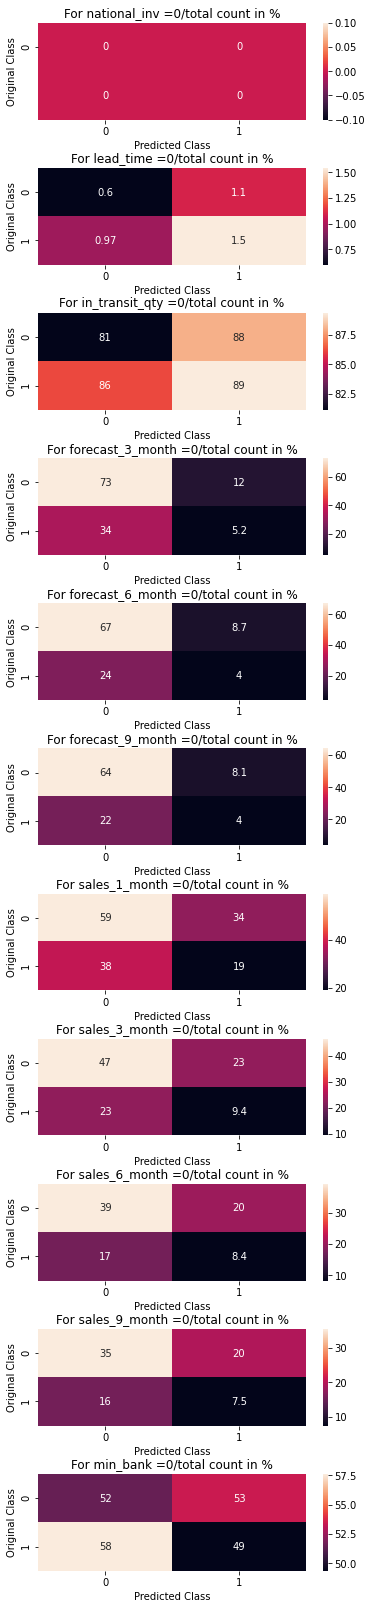

In [56]:

for i,col in enumerate(pair_cols):
    zero_analysis=[[(pred_tn[col]==0).sum()*100/pred_tn[col].count(),(pred_fp[col]==0).sum()*100/pred_fp[col].count()],
    [(pred_fn[col]==0).sum()*100/pred_fn[col].count(),(pred_tp[col]==0).sum()*100/pred_tp[col].count()]]
    plt.subplot(len(pair_cols),1,i+1)
    sns.heatmap(np.array(zero_analysis),annot=True)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("For "+col+" =0/total count in %")
    plt.subplots_adjust(top=5.5,hspace=0.5)
plt.show()

#### Analysis ofbox plots for each of TP,TN,FP and FN:

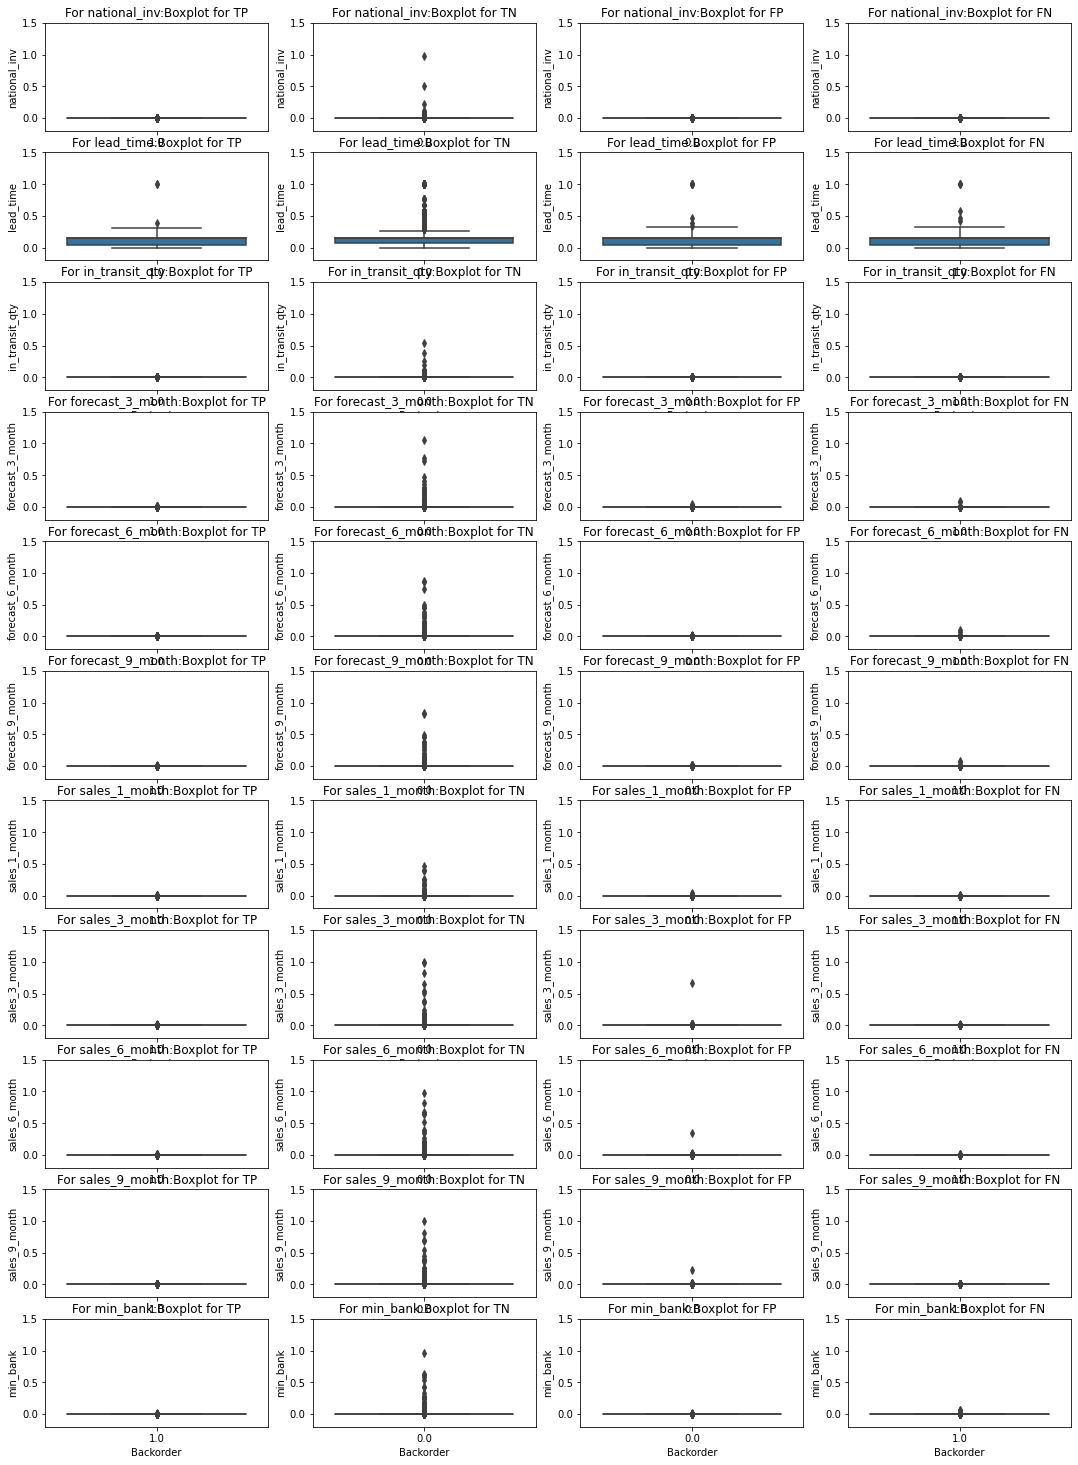

In [72]:
pred_conf = [pred_tp,pred_tn,pred_fp,pred_fn]
conf_strings = ['TP','TN','FP','FN',]
for i,col in enumerate(pair_cols):
    for j,data in enumerate(pred_conf):
        plt.subplot(len(pair_cols),len(pred_conf),(len(pred_conf)*i)+j+1)
        plt.ylim([-0.2,1.5])
        sns.boxplot(y=col,x='went_on_backorder_Yes',data=data,)
        plt.xlabel('Backorder')
        plt.ylabel(col)
        plt.title("For "+col+":Boxplot for "+conf_strings[j])
        plt.subplots_adjust(top=5, right=2.5)
plt.show()

In [16]:
cat_cols=['forecast','sales','potential_issue_Yes','deck_risk_Yes',
 'oe_constraint_Yes','ppap_risk_Yes','stop_auto_buy_Yes','rev_stop_Yes']
pred_tp['status']='TP'
pred_tn['status']='TN'
pred_fp['status']='FP'
pred_fn['status']='FN'
cat_pred = pd.concat([pred_tp,pred_tn,pred_fp,pred_fn])

In [17]:
cat_pred.columns

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
       'local_bo_qty', 'forecast', 'sales', 'potential_issue_Yes',
       'deck_risk_Yes', 'oe_constraint_Yes', 'ppap_risk_Yes',
       'stop_auto_buy_Yes', 'rev_stop_Yes', 'went_on_backorder_Yes', 'pred',
       'status'],
      dtype='object')

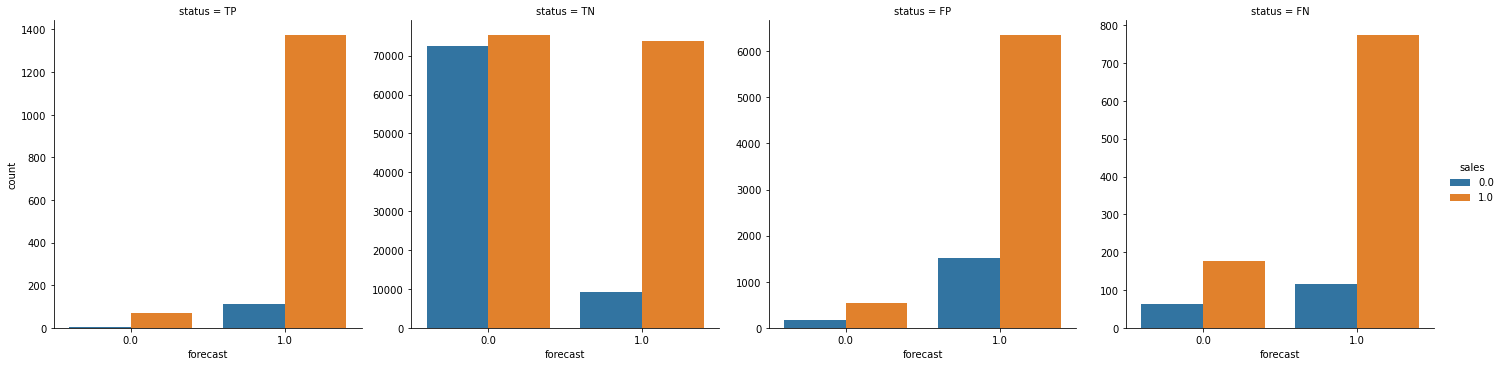

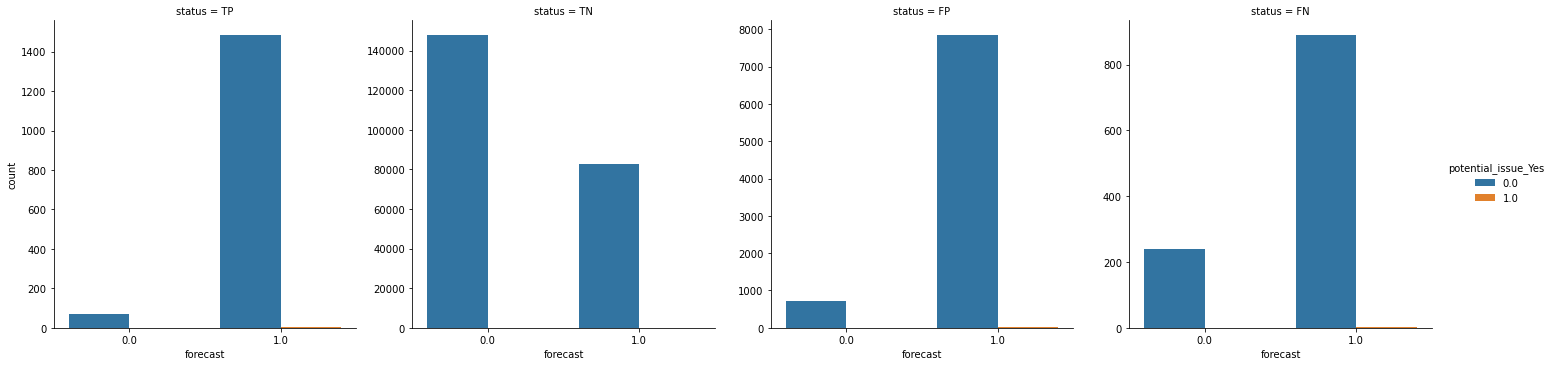

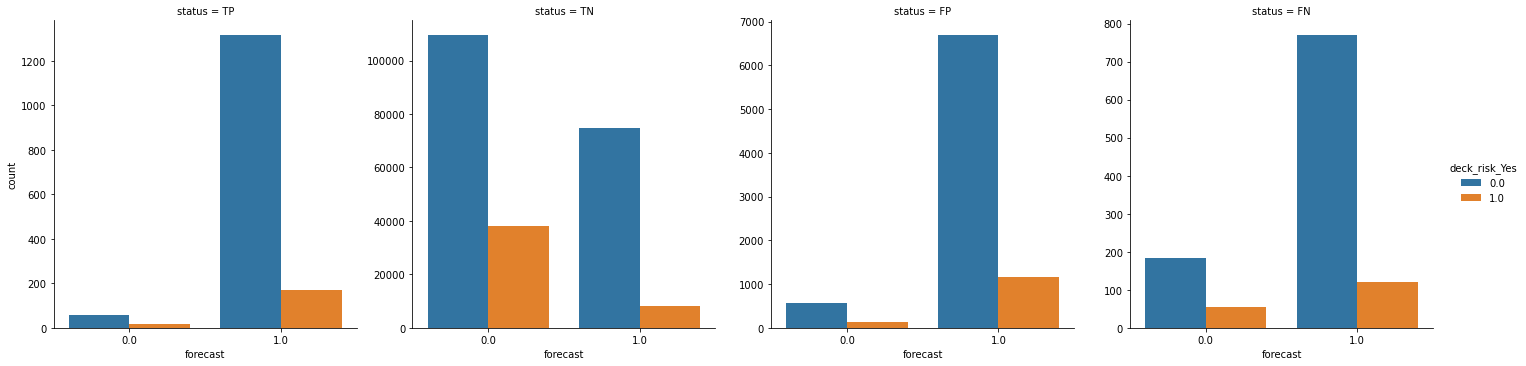

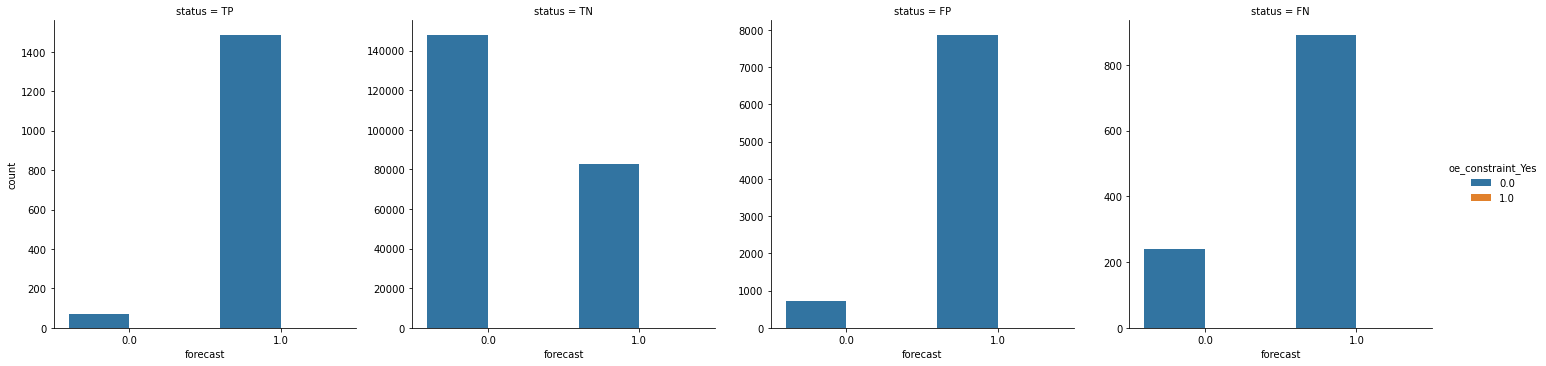

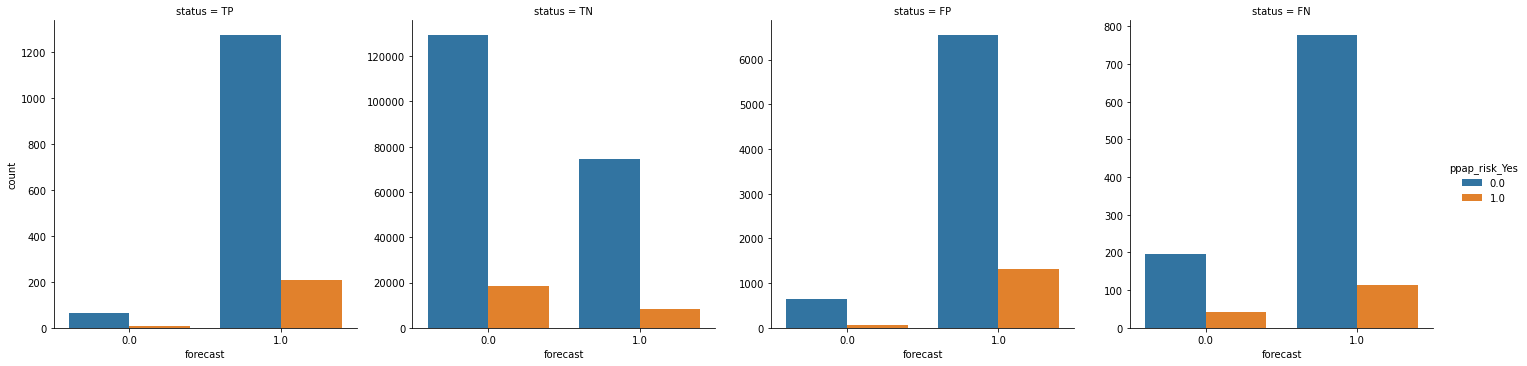

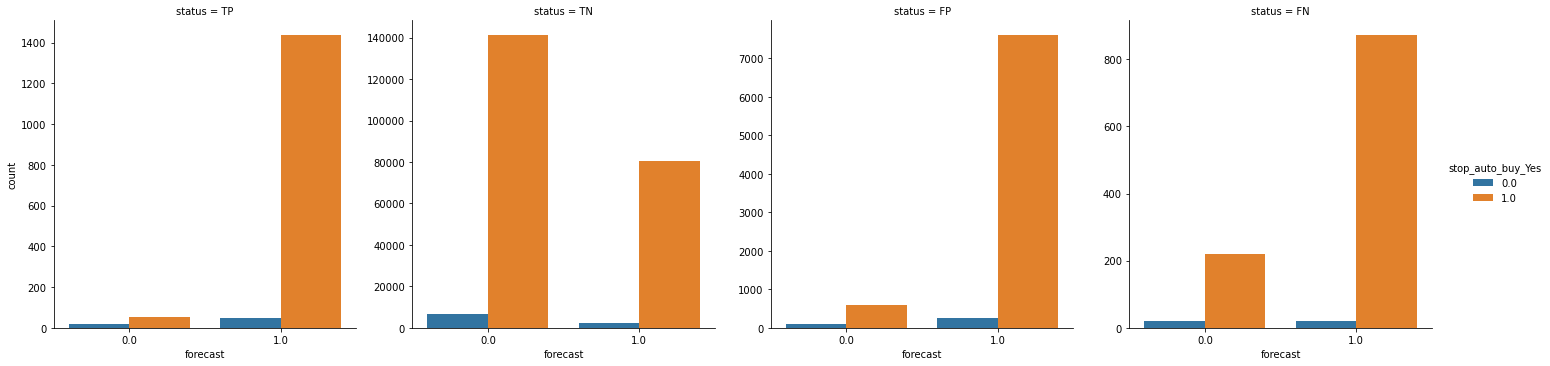

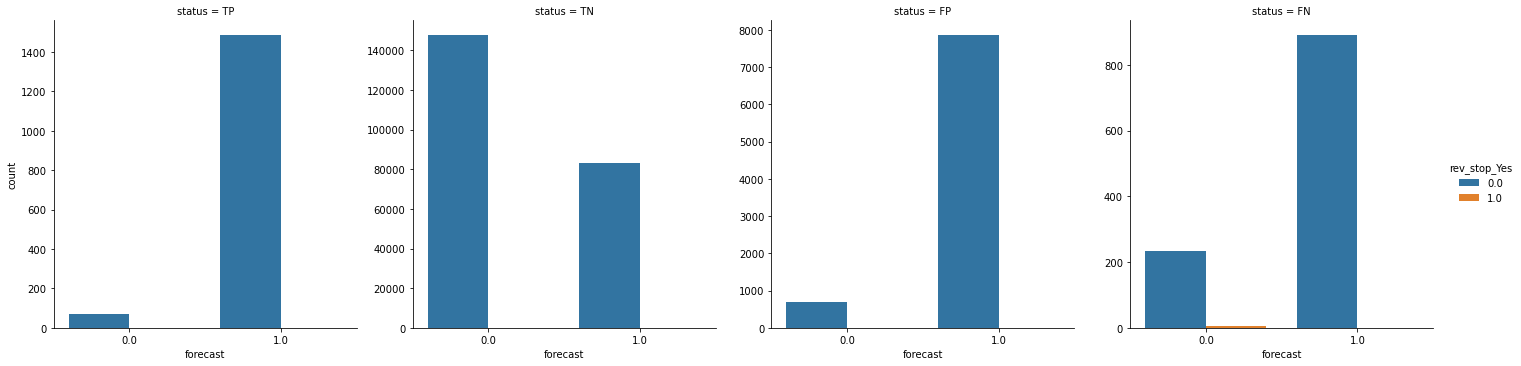

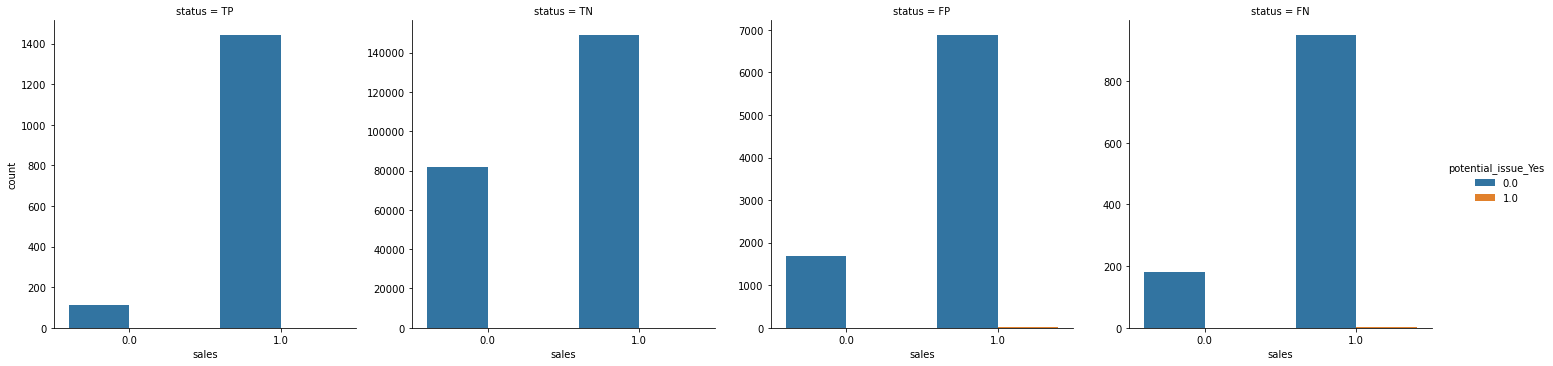

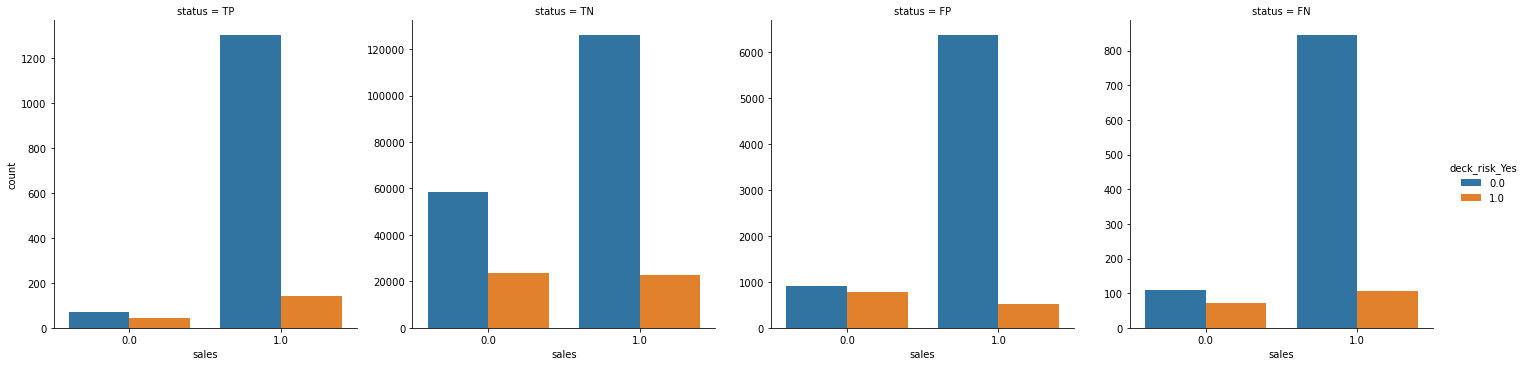

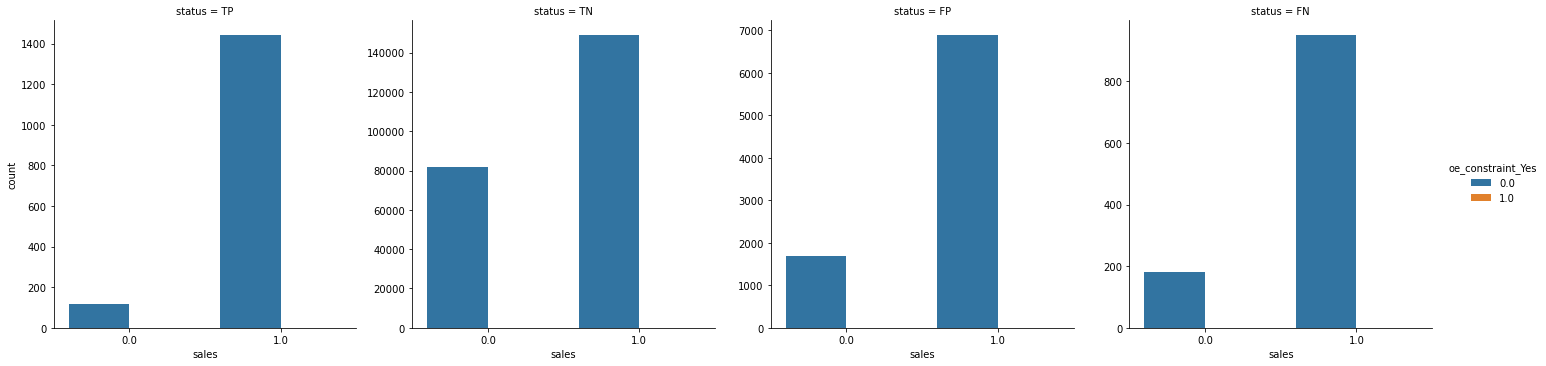

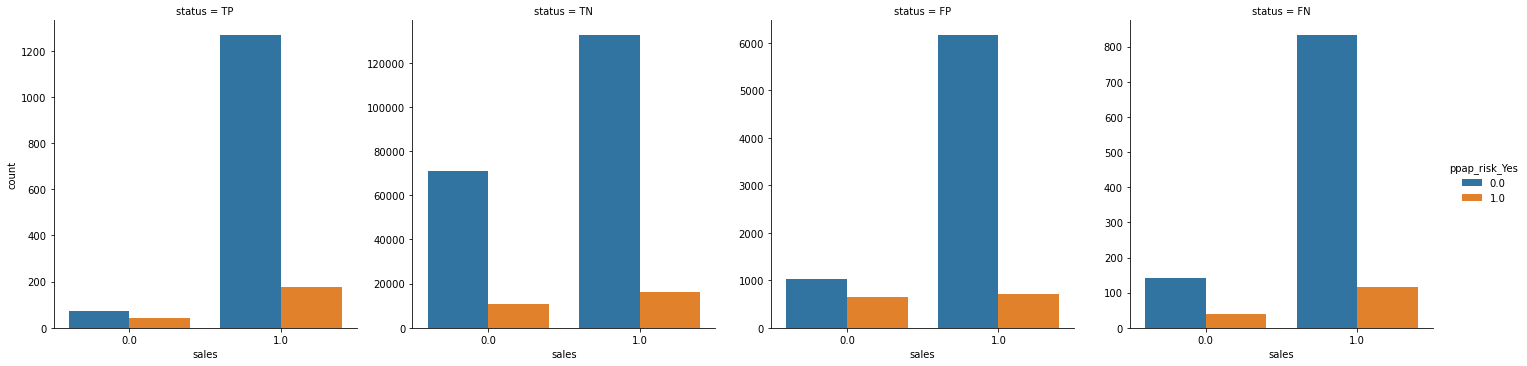

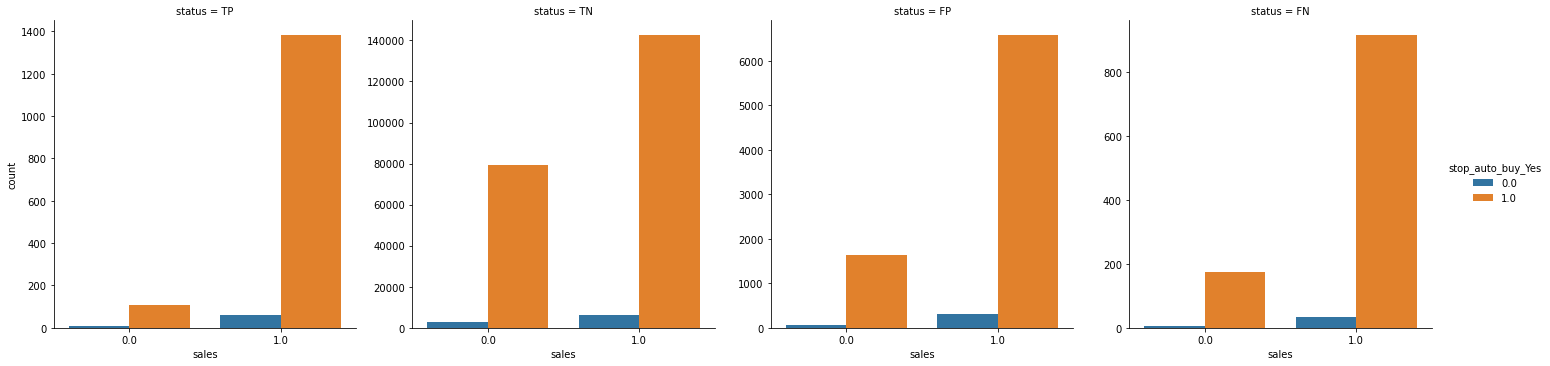

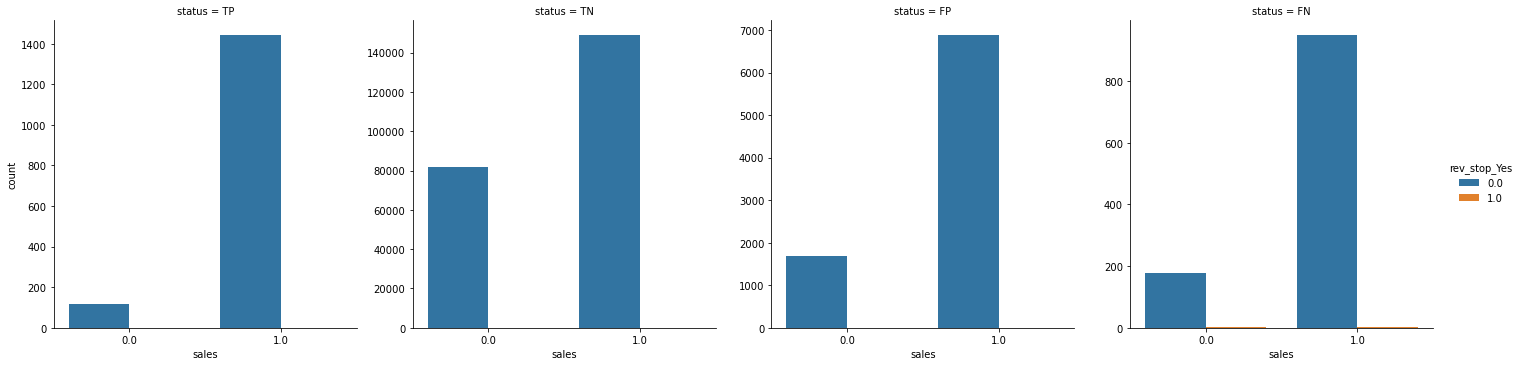

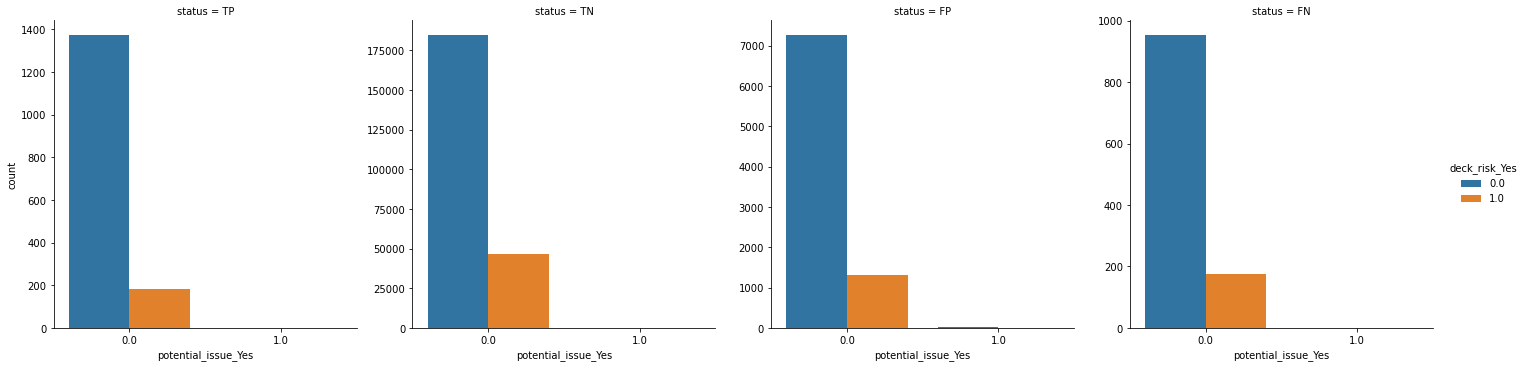

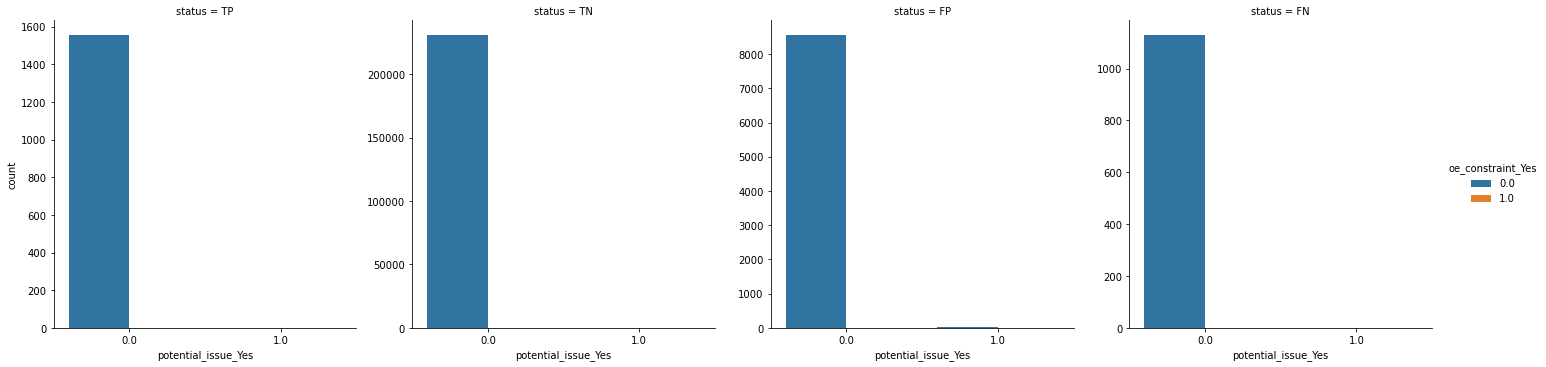

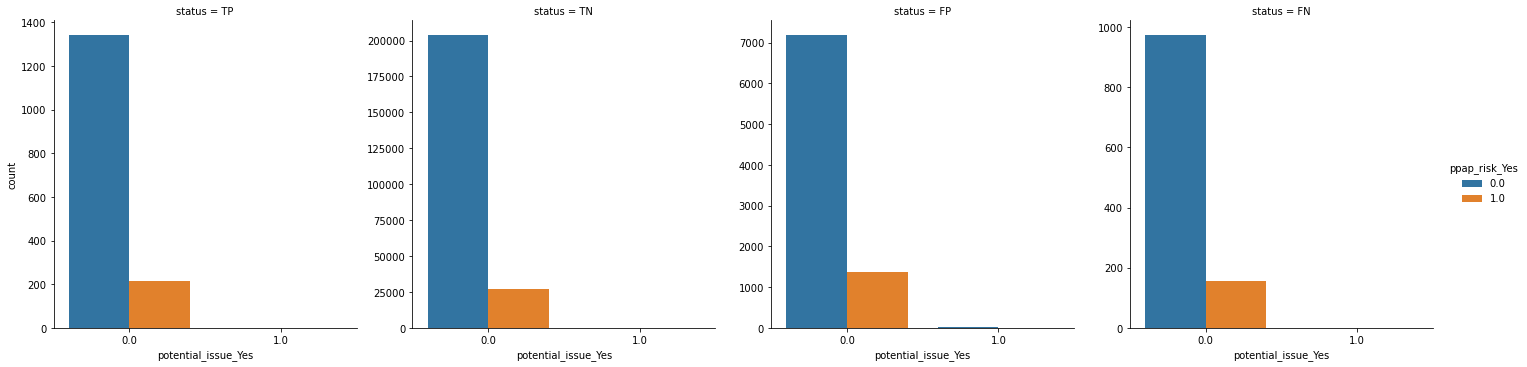

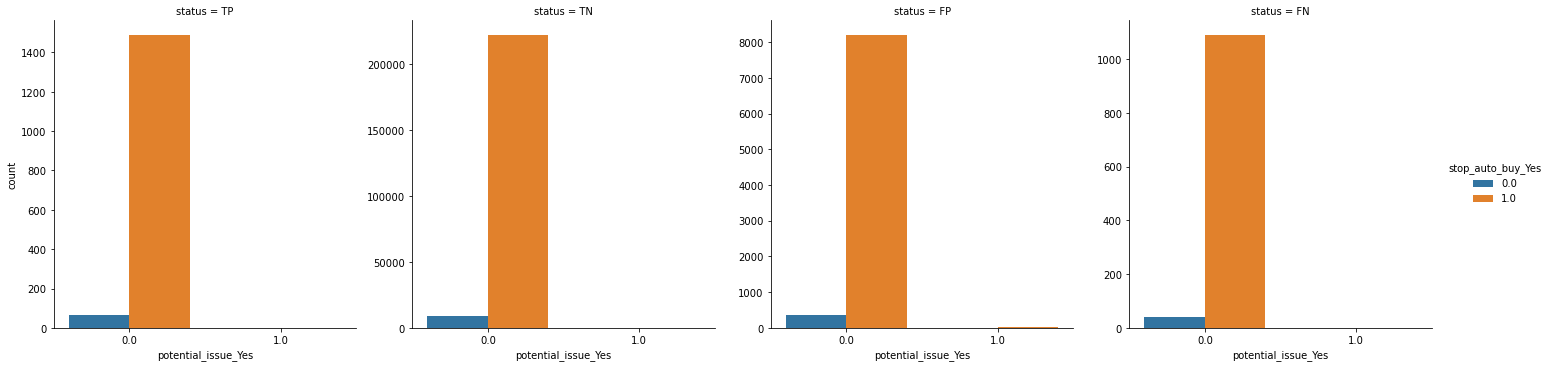

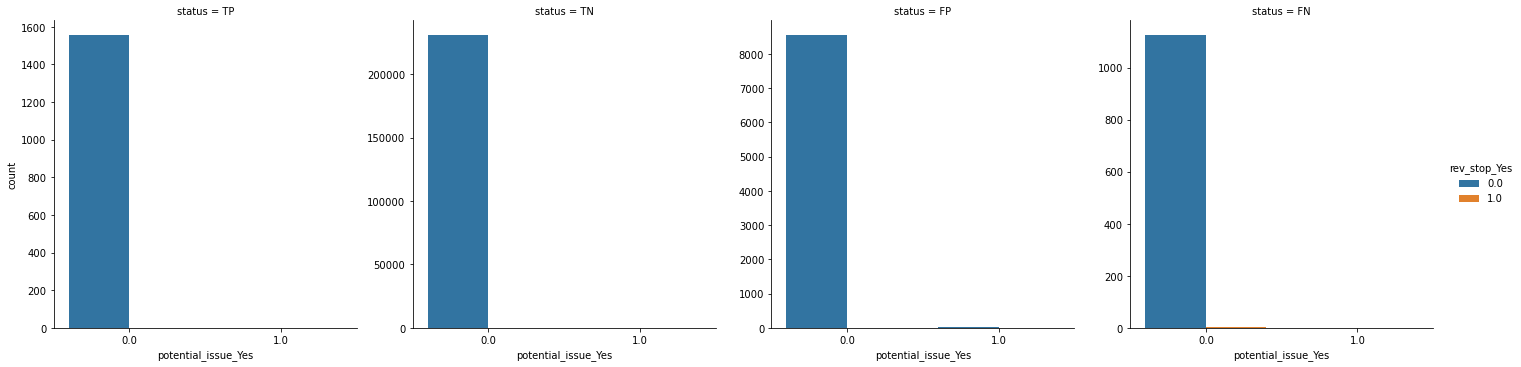

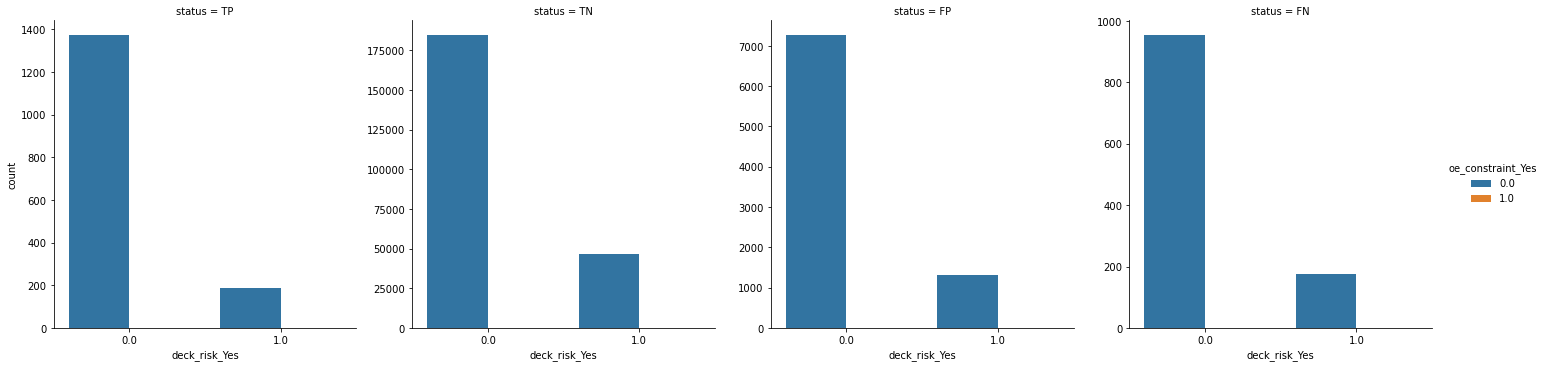

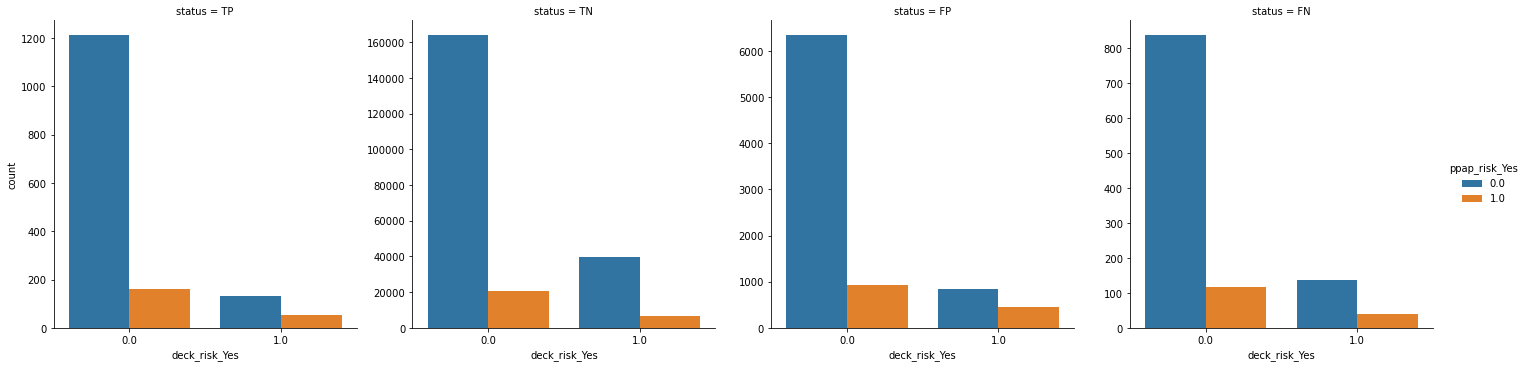

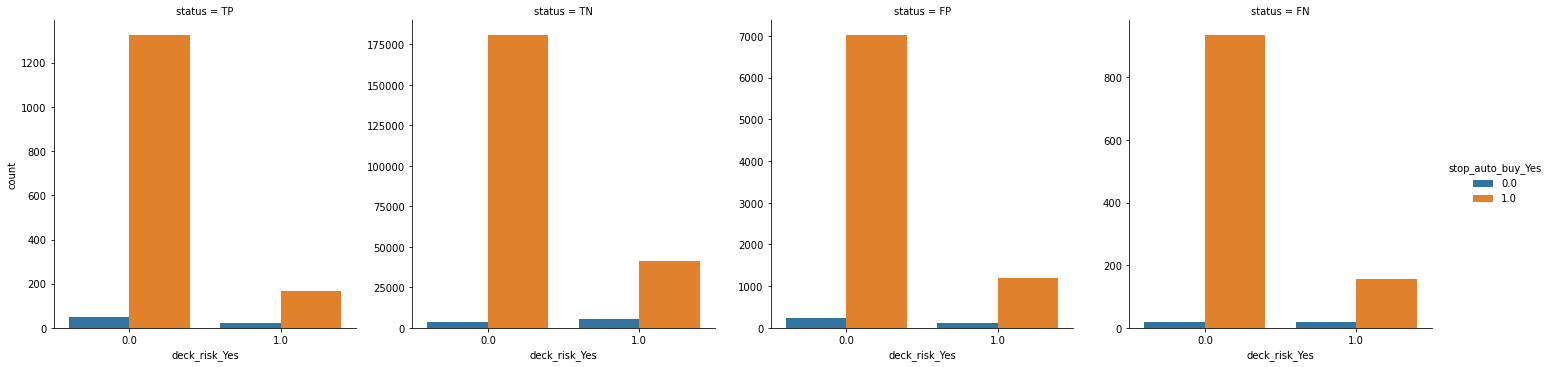

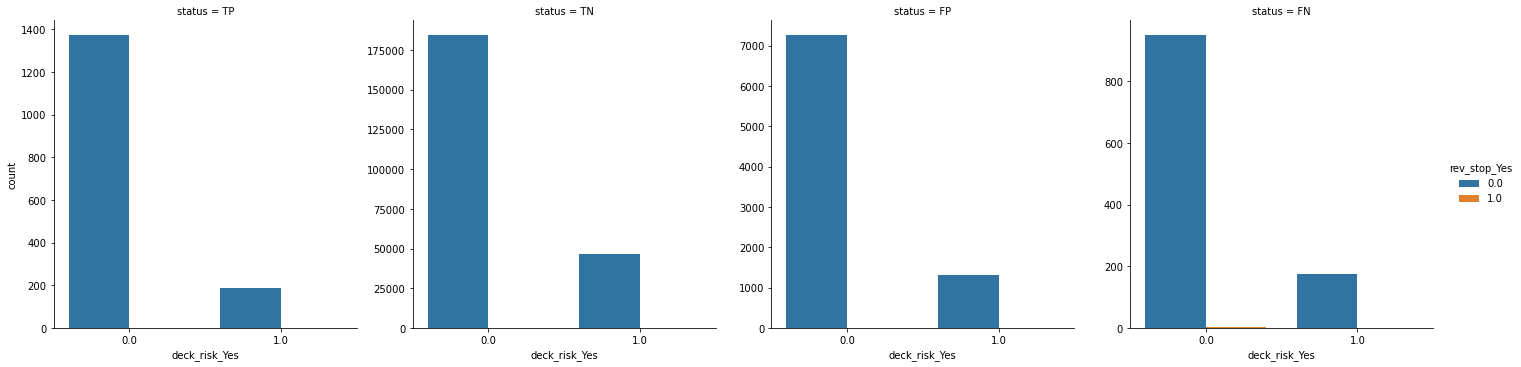

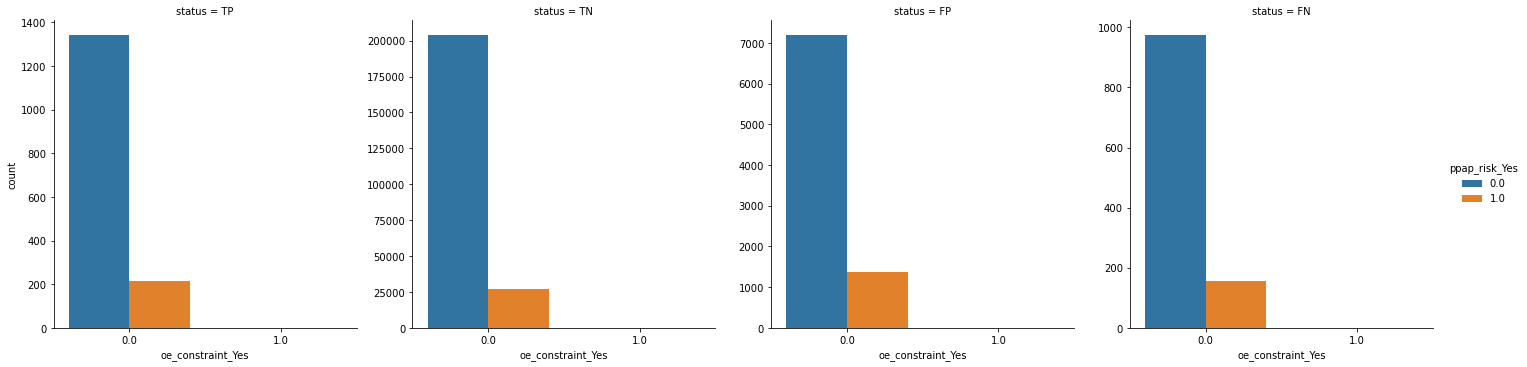

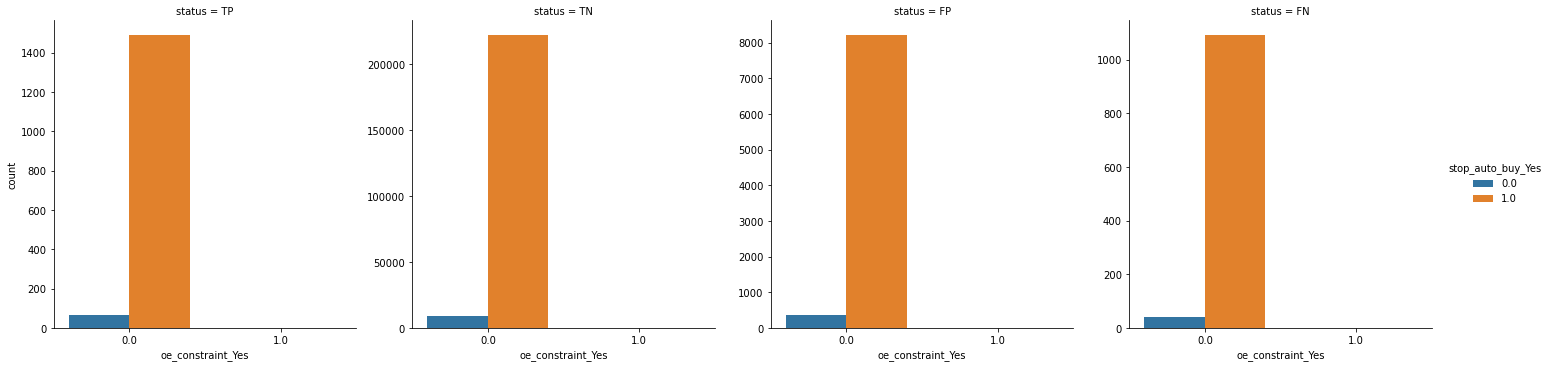

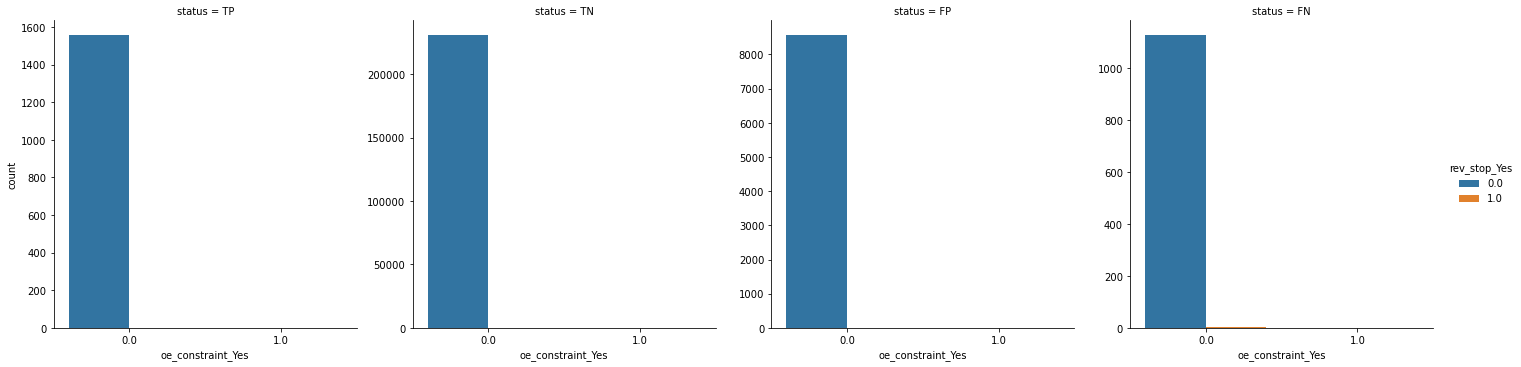

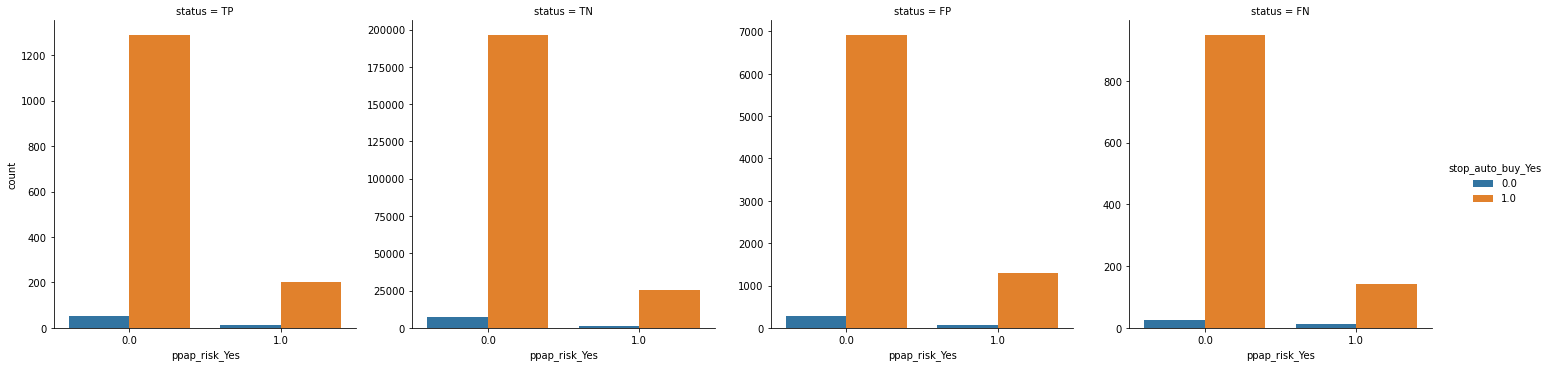

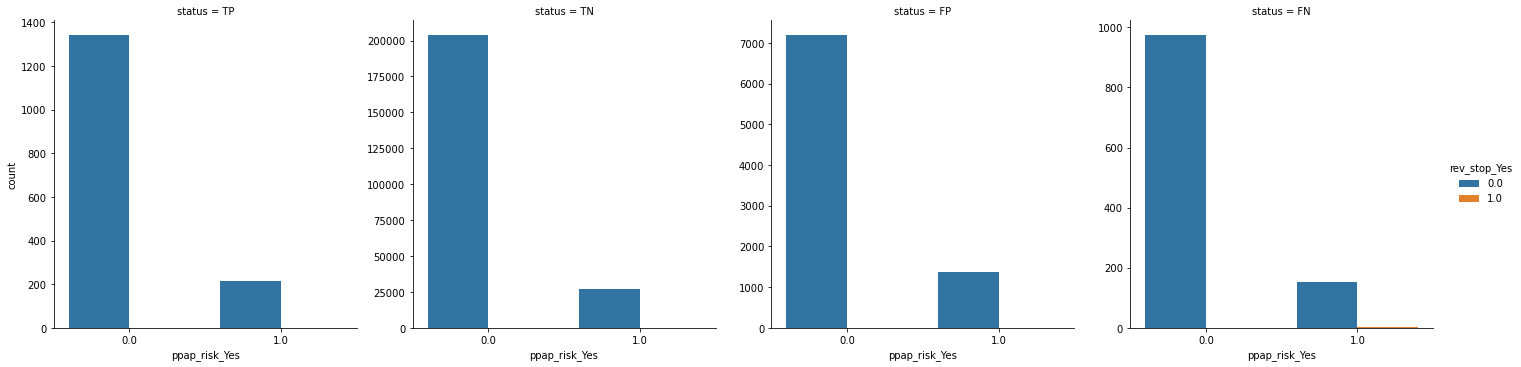

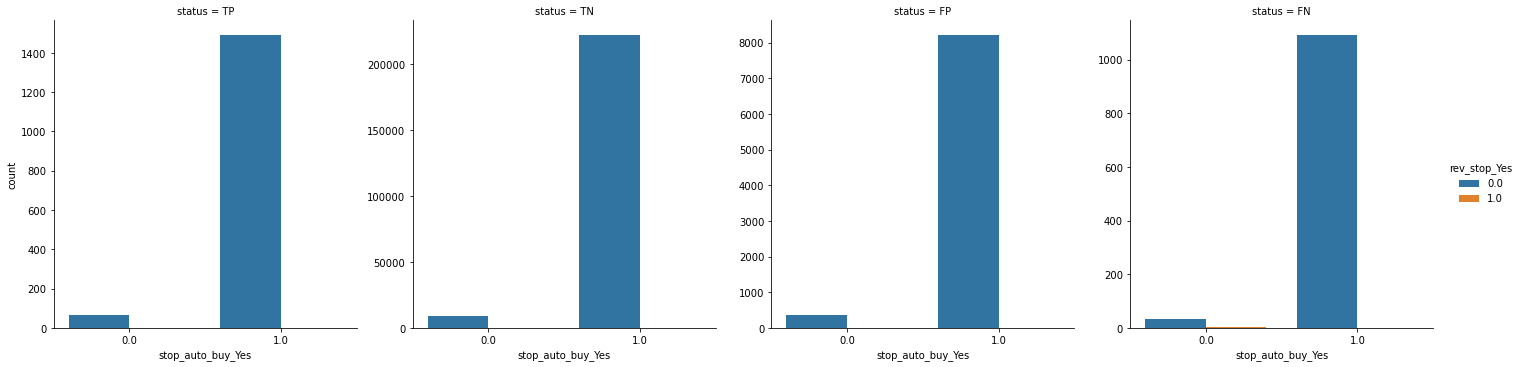

In [103]:
for i,cols in enumerate(cat_cols):
    for j,cols_2 in enumerate(cat_cols):
        if(i<j):
            sns.catplot(cols,hue=cols_2,col='status',data=cat_pred,kind='count',sharey=False)



#### Analysis to check which features have the least importance if predictng TP,FP,TN,FN 

In [27]:
pred_ana = cat_pred.drop(columns=['went_on_backorder_Yes', 'pred'])
pred_ana.replace({'TN':0,'TP':1,'FN':2,'FP':3},inplace=True)
ana_X = pred_ana.iloc[:,:-1]
ana_y = pred_ana.iloc[:,-1]

In [28]:
clf_2 = RandomForestClassifier().fit(ana_X,ana_y)

In [29]:
ana_pred = clf_2.predict(ana_X)
accuracy_score(ana_y,ana_pred)

0.9988598574821853

In [30]:
f1_score(ana_y,ana_pred,average='macro')

0.9789530960520926

In [31]:
ana_X.columns[np.argsort(clf_2.feature_importances_)[:5]]

Index(['oe_constraint_Yes', 'rev_stop_Yes', 'potential_issue_Yes', 'sales',
       'stop_auto_buy_Yes'],
      dtype='object')

In [24]:
smote_x.columns[np.argsort(clf.feature_importances_)[:5]]

Index(['forecast', 'oe_constraint_Yes', 'potential_issue_Yes', 'rev_stop_Yes',
       'sales'],
      dtype='object')

In [32]:
Counter(ana_pred)

Counter({1: 1537, 3: 8578, 0: 230962, 2: 998})

In [78]:
smote_x_rem = smote_x.drop(columns=['rev_stop_Yes', 'potential_issue_Yes', 'oe_constraint_Yes'])
test_x_rem = test_x.drop(columns=['rev_stop_Yes', 'potential_issue_Yes', 'oe_constraint_Yes'])

clf_rem = XGBClassifier(eta=0.3,max_depth=10,eval_metric='aucpr')
clf_rem.fit(smote_x_rem,smote_y)
preds_rem = clf_rem.predict(test_x_rem)
f1_score(test_y,preds_rem)

0.24258425221307653

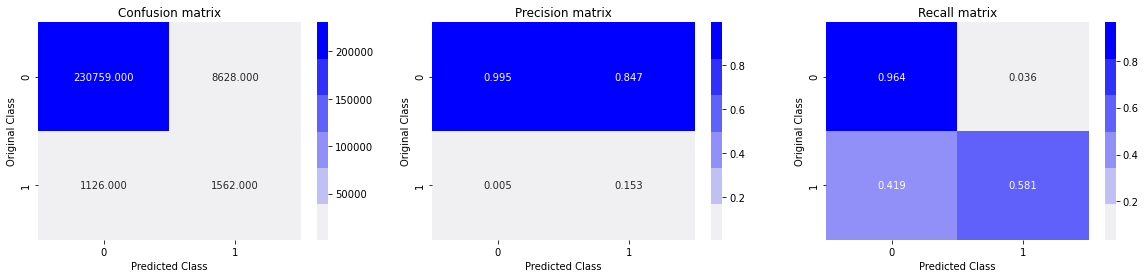

In [79]:
plot_confusion_matrix(test_y, preds_rem)